In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import missingno as msno
sns.set(style='darkgrid')
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    classification_report
)

In [2]:
RANDOM_STATE = 42
# THRESHOLD_PERCENTILE = 85 

In [3]:
df = pd.read_csv('All_dataset.csv', encoding="utf-8", encoding_errors="replace")

In [4]:
# removing leading/trailing whitespace in col names
col_names = {col: col.strip() for col in df.columns}
df.rename(columns = col_names, inplace = True)

# fix the encoding issues in the label
df['Label'] = df['Label'] \
    .str.replace('ï¿½', '-', regex=False) \
    .str.replace('�', '-', regex=False) \
    .str.strip()

In [5]:
df['AttackBinary'] = df['Label'].apply(lambda x: 'Normal' if x == 'BENIGN' else 'Attack')

In [6]:
# handle duplicates
df.drop_duplicates(inplace = True)


# handle missing values
missing_values = df.isnull().sum()
missing_values

print(missing_values.loc[missing_values > 0])


# check infinity values
numeric_cols = df.select_dtypes(include = np.number).columns
inf_count = np.isinf(df[numeric_cols]).sum()
print(inf_count[inf_count > 0])

Flow Bytes/s    353
dtype: int64
Flow Bytes/s      1211
Flow Packets/s    1564
dtype: int64


In [7]:
inf_rows = df[np.isinf(df['Flow Bytes/s']) | np.isinf(df['Flow Packets/s'])]
print('Rows with infinity values in \'Flow Bytes/s\' or \'Flow Packets/s\':')
display(inf_rows[['Flow Bytes/s', 'Flow Packets/s', 'Label']].sample(5))

Rows with infinity values in 'Flow Bytes/s' or 'Flow Packets/s':


,Flow Bytes/s,Flow Packets/s,Label
2819430,inf,inf,BENIGN
752001,NaN,inf,BENIGN
1402408,inf,inf,BENIGN
609876,NaN,inf,BENIGN
2510335,inf,inf,BENIGN


In [8]:
# replace infinite values with NaN
print(f'Initial missing values: {df.isna().sum().sum()}')

df.replace([np.inf, -np.inf], np.nan, inplace = True)

print(f'Missing values after processing infinite values: {df.isna().sum().sum()}')

Initial missing values: 353
Missing values after processing infinite values: 3128


In [9]:
missing = df.isna().sum()
print(missing.loc[missing > 0])

Flow Bytes/s      1564
Flow Packets/s    1564
dtype: int64


In [10]:
fb_median = df['Flow Bytes/s'].median()
fp_median = df['Flow Packets/s'].median()

print('Median of Flow Bytes/s: ', fb_median)
print('Median of Flow Packets/s: ', fp_median)

# Fill missing values with median
df['Flow Bytes/s'].fillna(fb_median, inplace = True)
df['Flow Packets/s'].fillna(fp_median, inplace = True)

Median of Flow Bytes/s:  3715.0378579999997
Median of Flow Packets/s:  69.742244285


C:\Users\USER\AppData\Local\Temp\ipykernel_492\210869509.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Flow Bytes/s'].fillna(fb_median, inplace = True)
C:\Users\USER\AppData\Local\Temp\ipykernel_492\210869509.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example

In [11]:
print('Number of \'Flow Bytes/s\' missing values:', df['Flow Bytes/s'].isna().sum())
print('Number of \'Flow Packets/s\' missing values:', df['Flow Packets/s'].isna().sum())

Number of 'Flow Bytes/s' missing values: 0
Number of 'Flow Packets/s' missing values: 0


In [12]:
# Creating a dictionary that maps each label to its attack type
attack_map = {
    'BENIGN': 'BENIGN',
    'DDoS': 'DDoS',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'PortScan': 'Port Scan',
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bot',
    'Web Attack - Brute Force': 'Web Attack',
    'Web Attack - XSS': 'Web Attack',
    'Web Attack - Sql Injection': 'Web Attack',
    'Infiltration': 'Infiltration',
    'Heartbleed': 'Heartbleed'
}

In [13]:
df['Attack Type'] = df['Label'].map(attack_map)

In [14]:
df['Attack Type'].value_counts()

Attack Type
BENIGN          2096484
DoS              193748
DDoS             128016
Port Scan         90819
Brute Force        9152
Web Attack         2143
Bot                1953
Infiltration         36
Heartbleed           11
Name: count, dtype: int64

In [15]:
df.drop('Label', axis = 1, inplace = True)

df['AttackBinary'].unique()

df['Attack Type'].unique()

array(['BENIGN', 'Brute Force', 'DoS', 'Heartbleed', 'Web Attack',
       'Infiltration', 'Bot', 'Port Scan', 'DDoS'], dtype=object)

In [16]:
# Dropping columns with only one unique value
num_unique = df.nunique()
one_variable = num_unique[num_unique == 1]
not_one_variable = num_unique[num_unique > 1].index

dropped_cols = one_variable.index
data = df[not_one_variable]

print('Dropped columns:')
dropped_cols

Dropped columns:


Index(['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk',
       'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk',
       'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'],
      dtype='object')

In [17]:
df['AttackBinary'] = df['AttackBinary'].map({'Normal': 0, 'Attack': 1})

In [18]:
SELECTED_FEATURES = [
    # Flow characteristics
    'Flow Duration',
    'Total Fwd Packets',
    'Total Backward Packets',
    'Down/Up Ratio',
    
    'Average Packet Size',
    'Packet Length Mean',
    'Packet Length Std',
    'Min Packet Length',
    'Max Packet Length',
    'Packet Length Variance',
    
    'Fwd Packets/s',
    'Bwd Packets/s',
    
    'SYN Flag Count',
    'FIN Flag Count',
    'RST Flag Count',
    'PSH Flag Count',
    'ACK Flag Count',
    'URG Flag Count',
    
    'Init_Win_bytes_forward',
    'Init_Win_bytes_backward',
    'Avg Fwd Segment Size',
    'Avg Bwd Segment Size',
    
    'Destination Port',
    'Fwd Header Length',
    'Bwd Header Length',
    'Subflow Fwd Packets',
    'Subflow Bwd Packets'
]


In [19]:
# Filter to only include features that exist in the dataframe
available_features = [f for f in SELECTED_FEATURES if f in df.columns]
print(f"\n📊 Using {len(available_features)} selected features out of {len(SELECTED_FEATURES)} requested")
print(f"Features used: {available_features}\n")


📊 Using 27 selected features out of 27 requested
Features used: ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Down/Up Ratio', 'Average Packet Size', 'Packet Length Mean', 'Packet Length Std', 'Min Packet Length', 'Max Packet Length', 'Packet Length Variance', 'Fwd Packets/s', 'Bwd Packets/s', 'SYN Flag Count', 'FIN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Destination Port', 'Fwd Header Length', 'Bwd Header Length', 'Subflow Fwd Packets', 'Subflow Bwd Packets']



**Model Training**

In [20]:
y = df["AttackBinary"]

In [21]:
X = df[available_features]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=RANDOM_STATE
)

In [23]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
CONTAMINATION = len(y_train[y_train == 1]) / len(y_train)

print(f'Contamination in training set: {CONTAMINATION:.4f}')

Contamination in training set: 0.1688


In [25]:
iso_forest = IsolationForest(
    n_estimators=300,
    contamination=CONTAMINATION,
    random_state=RANDOM_STATE,
    max_samples='auto',
    n_jobs=-1
)

In [26]:
iso_forest.fit(X_train_scaled)

,n_estimators,300
,max_samples,'auto'
,contamination,0.16884080343368738
,max_features,1.0
,bootstrap,False
,n_jobs,-1
,random_state,42
,verbose,0
,warm_start,False


In [27]:
train_scores = -iso_forest.decision_function(X_train_scaled)
test_scores = -iso_forest.decision_function(X_test_scaled)

In [28]:
# attack_ratio = float(y_train.mean() * 100)
# THRESHOLD_PERCENTILE = round(100 - attack_ratio, 2)
# threshold = np.percentile(train_scores, THRESHOLD_PERCENTILE)
# print(f'Threshold at {THRESHOLD_PERCENTILE} percentile: {threshold:.4f}')

In [35]:
THRESHOLD_PERCENTILE = 81.0
threshold = -0.0073
print(f'Threshold at {THRESHOLD_PERCENTILE} percentile: {threshold:.4f}')

Threshold at 81.0 percentile: -0.0073


F1-optimal threshold

In [ ]:
# from sklearn.metrics import f1_score

# percentiles = np.arange(60, 95, 0.5)
# best_f1 = 0
# best_p = None
# best_threshold = None

# for p in percentiles:
#     t = np.percentile(train_scores, p)
#     preds = (train_scores >= t).astype(int)
#     f1 = f1_score(y_train, preds)

#     if f1 > best_f1:
#         best_f1 = f1
#         best_p = p
#         best_threshold = t

# print(f"Best percentile: {best_p}")
# print(f"Best threshold: {best_threshold:.4f}")
# print(f"Train F1: {best_f1:.4f}")


Best percentile: 81.0
Best threshold: -0.0069
Train F1: 0.5436


ROC-based threshold

In [ ]:
# from sklearn.metrics import roc_curve

# fpr, tpr, thresholds = roc_curve(y_train, train_scores)
# j_scores = tpr - fpr
# idx = np.argmax(j_scores)

# best_threshold = thresholds[idx]
# print(f'Optimal threshold by Youden\'s J statistic: {best_threshold:.4f}')

Optimal threshold by Youden's J statistic: -0.0073


In [36]:
# Prediction logic: If score > threshold, it's an Attack (1)
y_pred = (test_scores >= threshold).astype(int)

**Evaluation**

In [37]:
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, test_scores)
avg_precision = average_precision_score(y_test, test_scores)
precision, recall, _ = precision_recall_curve(y_test, test_scores)

In [38]:
print("\n==============================")
print("Isolation Forest Evaluation")
print("==============================")
print(f"F1 Score        : {f1:.4f}")
print(f"ROC-AUC         : {roc_auc:.4f}")
print(f"Avg Precision   : {avg_precision:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["BENIGN", "ATTACK"]))


Isolation Forest Evaluation
F1 Score        : 0.5395
ROC-AUC         : 0.7706
Avg Precision   : 0.3672

Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.91      0.89      0.90    419297
      ATTACK       0.51      0.58      0.54     85176

    accuracy                           0.83    504473
   macro avg       0.71      0.73      0.72    504473
weighted avg       0.84      0.83      0.84    504473



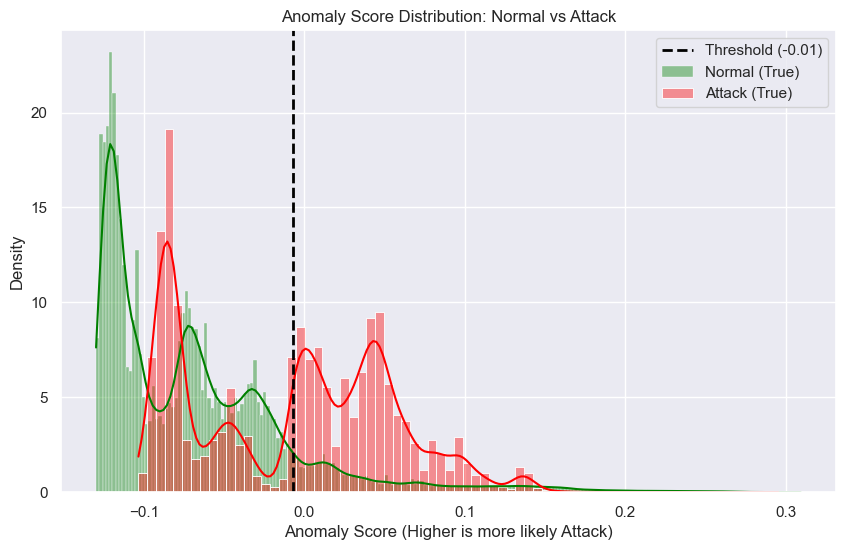

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(test_scores[y_test==0], color='green', label='Normal (True)', kde=True, stat="density", alpha=0.4)
sns.histplot(test_scores[y_test==1], color='red', label='Attack (True)', kde=True, stat="density", alpha=0.4)
plt.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.2f})')
plt.title('Anomaly Score Distribution: Normal vs Attack')
plt.xlabel('Anomaly Score (Higher is more likely Attack)')
plt.legend()
plt.show()

In [42]:
MODEL_PATH = "baseline_model.pkl"

joblib.dump(
    {
        "model": iso_forest,
        "scaler": scaler,
        "threshold": threshold,
        "threshold_percentile": THRESHOLD_PERCENTILE,
        "contamination": CONTAMINATION,
        "features": SELECTED_FEATURES
    },
    MODEL_PATH
)

print(f"✅ Model bundle saved to {MODEL_PATH}")

✅ Model bundle saved to baseline_model.pkl


In [40]:
set_selected = set(SELECTED_FEATURES)
set_x = set(X.columns.tolist())

print("✔ In SELECTED_FEATURES but NOT in X.columns:", set_selected - set_x)
print("✔ In X.columns but NOT in SELECTED_FEATURES:", set_x - set_selected)


✔ In SELECTED_FEATURES but NOT in X.columns: set()
✔ In X.columns but NOT in SELECTED_FEATURES: set()


In [41]:
print("Order matches:", SELECTED_FEATURES == X.columns.tolist())


Order matches: True


In [ ]:
# param_grid = {
#     "n_estimators": [200, 300, 400],
#     "max_samples": ["auto", 0.6, 0.8],
#     "contamination": [0.12, 0.15, 0.18],
#     "threshold_percentile": [75, 80, 83, 85, 88]
# }

# results = []

# # =====================================================
# # GRID SEARCH (MANUAL)
# # =====================================================
# for n_estimators in param_grid["n_estimators"]:
#     for max_samples in param_grid["max_samples"]:
#         for contamination in param_grid["contamination"]:

#             model = IsolationForest(
#                 n_estimators=n_estimators,
#                 max_samples=max_samples,
#                 contamination=contamination,
#                 random_state=42,
#                 n_jobs=-1
#             )

#             model.fit(X_train)

#             train_scores = -model.decision_function(X_train)
#             test_scores = -model.decision_function(X_test)

#             for p in param_grid["threshold_percentile"]:
#                 threshold = np.percentile(train_scores, p)
#                 y_pred = (test_scores >= threshold).astype(int)

#                 f1 = f1_score(y_test, y_pred)
#                 roc_auc = roc_auc_score(y_test, test_scores)
#                 pr_auc = average_precision_score(y_test, test_scores)

#                 results.append({
#                     "n_estimators": n_estimators,
#                     "max_samples": max_samples,
#                     "contamination": contamination,
#                     "threshold_percentile": p,
#                     "f1": f1,
#                     "roc_auc": roc_auc,
#                     "pr_auc": pr_auc
#                 })

# # =====================================================
# # RESULTS
# # =====================================================
# results_df = pd.DataFrame(results)
# results_df = results_df.sort_values(by="f1", ascending=False)

# print("\nTop 10 Configurations:")
# print(results_df.head(10))

# # =====================================================
# # BEST CONFIG
# # =====================================================
# best = results_df.iloc[0]
# print("\nBEST CONFIGURATION:")
# print(best)


Top 10 Configurations:
     n_estimators max_samples  contamination  threshold_percentile        f1  \
46            300        auto           0.12                    80  0.533548   
56            300        auto           0.18                    80  0.533548   
51            300        auto           0.15                    80  0.533548   
96            400        auto           0.15                    80  0.533291   
101           400        auto           0.18                    80  0.533291   
91            400        auto           0.12                    80  0.533291   
1             200        auto           0.12                    80  0.532835   
11            200        auto           0.18                    80  0.532835   
6             200        auto           0.15                    80  0.532835   
7             200        auto           0.15                    83  0.512779   

      roc_auc    pr_auc  
46   0.770120  0.366222  
56   0.770120  0.366222  
51   0.770120  0.

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.ensemble import IsolationForest
# from sklearn.metrics import (
#     f1_score, roc_auc_score, average_precision_score,
#     precision_score, recall_score, confusion_matrix
# )
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tqdm import tqdm
# import warnings
# warnings.filterwarnings('ignore')

# # =====================================================
# # CONFIGURATION
# # =====================================================

# print("="*70)
# print("🔧 HYPERPARAMETER + THRESHOLD TUNING (ISOLATION FOREST)")
# print("="*70)

# actual_contamination = y_train.sum() / len(y_train)

# print(f"\n📊 Dataset Statistics:")
# print(f"Training samples: {len(y_train)}")
# print(f"Test samples: {len(y_test)}")
# print(f"Attack rate: {actual_contamination:.4f} ({actual_contamination*100:.2f}%)")

# # =====================================================
# # PARAMETER GRID
# # =====================================================

# param_grid = {
#     "n_estimators": [200, 300, 400],
#     "max_samples": ["auto", 0.6, 0.8],
#     "max_features": [0.6, 0.8, 1.0],
#     "contamination": [0.12, 0.15, 0.18],
#     "threshold_percentile": [75, 80, 83, 85, 88]
# }

# # =====================================================
# # GRID SEARCH
# # =====================================================

# results = []
# best_f1_attack = 0
# best_config = None

# print("\n🚀 Starting grid search...\n")

# for n_estimators in param_grid["n_estimators"]:
#     for max_samples in param_grid["max_samples"]:
#         for max_features in param_grid["max_features"]:
#             for contamination in param_grid["contamination"]:

#                 try:
#                     model = IsolationForest(
#                         n_estimators=n_estimators,
#                         max_samples=max_samples,
#                         max_features=max_features,
#                         contamination=contamination,
#                         random_state=42,
#                         n_jobs=-1
#                     )

#                     model.fit(X_train_scaled)

#                     train_scores = -model.decision_function(X_train_scaled)
#                     test_scores = -model.decision_function(X_test_scaled)

#                     for percentile in param_grid["threshold_percentile"]:
#                         threshold = np.percentile(train_scores, percentile)
#                         y_pred = (test_scores >= threshold).astype(int)

#                         # Metrics
#                         f1_attack = f1_score(y_test, y_pred, pos_label=1)
#                         precision_attack = precision_score(y_test, y_pred, pos_label=1)
#                         recall_attack = recall_score(y_test, y_pred, pos_label=1)

#                         f1_benign = f1_score(y_test, y_pred, pos_label=0)
#                         roc_auc = roc_auc_score(y_test, test_scores)
#                         pr_auc = average_precision_score(y_test, test_scores)

#                         tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
#                         fpr = fp / (fp + tn)
#                         balanced_acc = ((tp / (tp + fn)) + (tn / (tn + fp))) / 2

#                         combined_score = 0.7 * f1_attack + 0.3 * roc_auc

#                         results.append({
#                             "n_estimators": n_estimators,
#                             "max_samples": max_samples,
#                             "max_features": max_features,
#                             "contamination": contamination,
#                             "threshold_percentile": percentile,
#                             "threshold": threshold,
#                             "f1_attack": f1_attack,
#                             "precision_attack": precision_attack,
#                             "recall_attack": recall_attack,
#                             "f1_benign": f1_benign,
#                             "roc_auc": roc_auc,
#                             "pr_auc": pr_auc,
#                             "balanced_accuracy": balanced_acc,
#                             "fpr": fpr,
#                             "combined_score": combined_score
#                         })

#                         if f1_attack > best_f1_attack:
#                             best_f1_attack = f1_attack
#                             best_config = results[-1]

#                 except Exception as e:
#                     print(f"⚠️ Skipped config due to error: {e}")

# print("\n✅ Grid search completed!")

# results_df = pd.DataFrame(results)


🔧 HYPERPARAMETER + THRESHOLD TUNING (ISOLATION FOREST)

📊 Dataset Statistics:
Training samples: 2017889
Test samples: 504473
Attack rate: 0.1688 (16.88%)

🚀 Starting grid search...



In [ ]:
best_row = results_df.loc[results_df['f1_attack'].idxmax()]

print("\n🥇 BEST CONFIGURATION (Attack-Focused)")
print("-"*60)
print(best_row)

In [33]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.
